## Conditional DDPM/DDIM
### [MNIST Code]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.resunet import ResUNet
import torch.nn.functional as F
import cv2
from pytorch_model_summary import summary
import math
import os

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


make directories

In [95]:
if not os.path.exists(f"content"):
    os.makedirs(f"content")

if not os.path.exists(f"content/ddpm"):
    os.makedirs(f"content/ddpm")

if not os.path.exists(f"content/ddim"):
    os.makedirs(f"content/ddim")

if not os.path.exists(f"weight"):
    os.makedirs(f"weight")

Show Function (input: tensor)

In [4]:
def imshow(img):
    '''
    input: tensor [1, h, w]
    '''
    d_img = (img[0] + 1.0) / 2.0
    plt.figure(figsize=(5,5))   
    plt.imshow(d_img, cmap='gray')
    plt.axis('off')
    plt.show()

## Training Process

GPU check

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset Loading

In [6]:
batch_size = 256
rsl = 32 

In [7]:
transform = transforms.Compose([transforms.Resize((rsl, rsl)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: (x*2) -1)])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

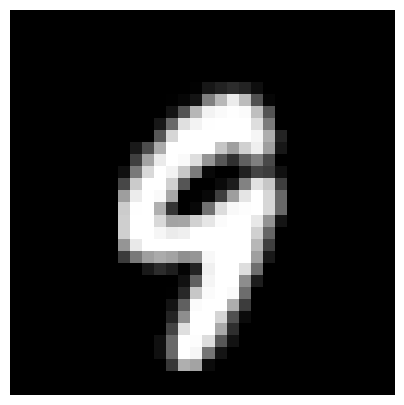

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]

imshow(image)

In [9]:
print(torch.min(image), torch.max(image))

tensor(-1.) tensor(1.)


Define Model

In [10]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [11]:
resolution=rsl
in_channels=1
std_cnl=64
ted=256
ced=64

In [12]:
model = ResUNet(resolution, in_channels, std_cnl, ted, ced).to(device)
model.train()

x = torch.ones([batch_size, in_channels, rsl, rsl]).cuda()
t = torch.ones([batch_size, ted]).cuda()
c = torch.ones([batch_size, ced]).cuda()

print(summary(model,x,t,c))
print('input:',x.shape,t.shape,c.shape)
print('output:',model(x,t,c).shape)
print('===================================')

model.apply(initialize_weights)

----------------------------------------------------------------------------------------------
      Layer (type)                               Output Shape         Param #     Tr. Param #
          Linear-1                                  [256, 64]          16,448          16,448
          Linear-2                                 [256, 128]          32,896          32,896
          Linear-3                                 [256, 256]          65,792          65,792
          Linear-4                                 [256, 512]         131,584         131,584
      InResBlock-5       [256, 64, 32, 32], [256, 64, 32, 32]          37,696          37,696
    DownResBlock-6     [256, 128, 16, 16], [256, 128, 16, 16]         221,696         221,696
    DownResBlock-7         [256, 256, 8, 8], [256, 256, 8, 8]         885,760         885,760
    ResAttnBlock-8                           [256, 256, 8, 8]       1,197,056       1,197,056
    DownResBlock-9         [256, 512, 4, 4], [256, 512, 4, 

ResUNet(
  (t_fc1): Linear(in_features=256, out_features=64, bias=True)
  (t_fc2): Linear(in_features=256, out_features=128, bias=True)
  (t_fc3): Linear(in_features=256, out_features=256, bias=True)
  (t_fc4): Linear(in_features=256, out_features=512, bias=True)
  (resblock_s1): InResBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu1): LeakyReLU(negative_slope=0.2)
    (leaky_relu2): LeakyReLU(negative_slope=0.2)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock_s2): DownResBlock(
    (down_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leaky_relu1): LeakyReLU(negative_slope=0.2)
    (leaky_relu2): LeakyReLU(negative_slope=0.2)
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.

Diffusion Model Parameters

In [13]:
def beta_schedule(timesteps=1000, linear=True):
    scale = 1000 / timesteps
    if linear: 
        beta_start = scale * 0.0001
        beta_end = scale * 0.01
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
    # quadratic 
    else:
        beta_start = (scale * 0.0001)**0.5
        beta_end = (scale * 0.01)**0.5
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)**2

beta_list = beta_schedule(timesteps=1000, linear=True)
alpha_list = 1.0 - beta_list
alpha_bar_list = torch.cumprod(alpha_list, dim=0)

sqrt_alpha_bar_list = torch.sqrt(alpha_bar_list)
sqrt_one_minus_alpha_bar_list = torch.sqrt(1.0 - alpha_bar_list)
one_div_sqrt_alpha_list = 1.0 / torch.sqrt(alpha_list)

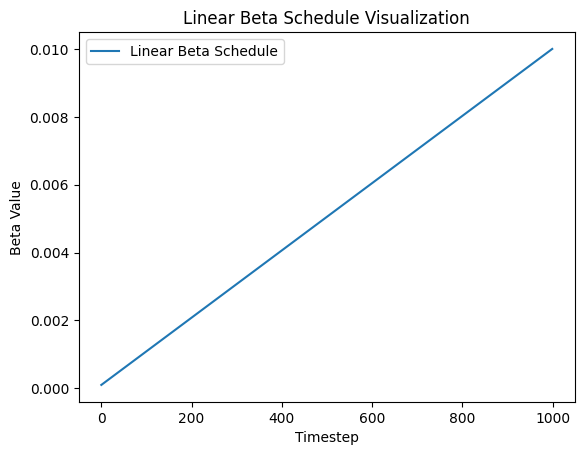

In [14]:
plt.plot(beta_list.numpy(), label='Linear Beta Schedule')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Linear Beta Schedule Visualization')
plt.legend()
plt.show()

Positional Encoding

In [15]:
def PE(pos_num, d_model, n):
    posses = np.arange(pos_num)

    i = np.arange(d_model)//2
    exponent = 2*i/d_model
    pos_emb = posses[:, np.newaxis] / np.power(n, exponent)

    pos_emb[:, 0::2] = np.sin(pos_emb[:, 0::2])
    pos_emb[:, 1::2] = np.cos(pos_emb[:, 1::2])

    pos_emb = torch.from_numpy(pos_emb).float()

    return pos_emb

Set Time Embedding

In [16]:
timestep_num = 1000
d_model = 256
n = 10000
t_emb_set = PE(pos_num=timestep_num, d_model=d_model, n=n).to(device)

Set Condition Embedding

In [17]:
condition_num = 10
d_model = 64
n = 1000
c_emb_set = PE(pos_num=condition_num, d_model=d_model, n=n).to(device)

Visualization Embedding

[340 178 546 647 299 712 133 456 426 593 737 426 989 474 367 534 503 846
 280 509 813 711 945 826 640 161 820 150 531 949 631 521 539  26 158  68
 922 734 925 623 214 991 200 830 806 476 570 958 275 754 879 915 520 450
 497 576 885 973 473 981 863 319 163 395 365 341 213 520 387 368 859 253
 509 629 164 919  90 323  70 300 626 294 999 645  79 398 840 534 164 552
 742 189 831 521 456 568 798 815  93 236 845 937 120 240 727 286 115 490
   9  30 591 527 478 770 695 783 177 501 232 946 110  39 590 595 289 554
 514 888 608 107 601 596 248 675 363 378  18   3 911 365 222 773 705 409
 448 240 323 418  67 820 607 386 265 397 235 256 653 943 598 885 517 232
 553 724 913 574 969 862 402 255 659 324 653 434 667 120 648 318 677 887
 583 256 398 808 145 693 290 882 826 470 427 693 834 294 936  27 168 533
 924 546 850 709 114 209 547  58 702 319 804 989 562  66 366 342 813 262
 343 498 811 560 931 721 388 314 972 944  58 931 452 863  49 459 668 924
 251 402 857 540 696 844 477 678 291 230 322 637 28

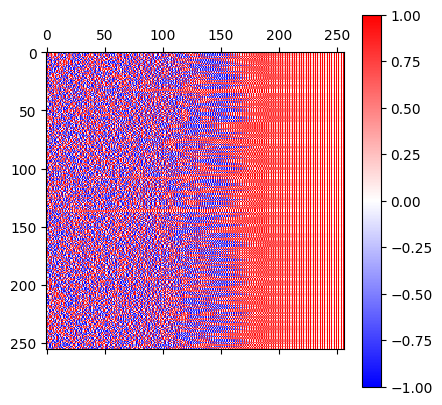

In [18]:
# get time embedding
t_test = np.random.randint(0,timestep_num,size=batch_size)
print(t_test)

t_emb_test = t_emb_set[t_test]
print(t_emb_test.shape)

# visualization
plt.matshow(t_emb_test.cpu(), cmap=plt.get_cmap('bwr'))
plt.colorbar()

Training Setting

In [16]:
learning_rate = 1e-4
epochs = 100

Set loss function and Optimizer

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
sch = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, total_iters=epochs)

Training

In [18]:
SAVE_PATH = './weight/ddpm_mnist'
BEST_SAVE_PATH = './weight/ddpm_mnist_best.pth'
LAST_SAVE_PATH = './weight/ddpm_mnist_last.pth'
losses = []
val_losses = [] 

In [19]:
print('-------------------------------------------------------------------')
print("Training Start")
print('-------------------------------------------------------------------\n')

epoch = 0 

for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0

    for iter, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        data_size = len(inputs)

        # get time embedding
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        emb_t = t_emb_set[t].to(device)

        # get condition embedding
        c = labels
        emb_c = c_emb_set[c].to(device)

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, 1, rsl, rsl), dtype=torch.float32).to(device)
        for i in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[i]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[i]]
            noise_img[i] = alpha_bar * inputs[i] + one_minus_alpha_bar * esp[i]

        # reverse process
        optimizer.zero_grad()
        output = model(noise_img, emb_t, emb_c)
        loss = criterion(output, esp)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # check loss per 50 iteration
        if (iter+1) % 50 == 0:
            print(f"[{iter+1}] Loss: {loss.item()}")

    # scheduler update
    sch.step()
    
    # record training loss
    losses.append(running_loss / len(train_loader))
    print('-------------------------------------------------------------------')
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    # save model per 10 epoch
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), SAVE_PATH+f'_{epoch+1}epoch.pth')
        print('<< model save at [%d] epoch! >>' % (epoch+1))

    '''
    -------------------------
    validation per one epoch
    -------------------------
    '''
    model.eval()
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        data_size = len(inputs)

        # get time embedding
        t = torch.randint(0, timestep_num, size=(data_size,), device=inputs.device).long()
        emb_t = t_emb_set[t].to(device)

        # get condition embedding
        c = labels
        emb_c = c_emb_set[c].to(device)

        # forward process
        esp = torch.randn_like(inputs).to(device)
        noise_img = torch.zeros((data_size, 1, rsl, rsl), dtype=torch.float32).to(device)
        for j in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[j]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[j]]
            noise_img[j] = alpha_bar * inputs[j] + one_minus_alpha_bar * esp[j]

        # reverse process
        output = model(noise_img, emb_t, emb_c)
        loss = criterion(output, esp)
        val_running_loss += loss.item()

    # calculate avg val loss
    val_loss = val_running_loss / len(test_loader)

    # early stopping
    if (epoch+1) > 1: 
        if val_loss < min(val_losses):
            best_epoch = epoch
            best_loss = np.round(val_loss,4)
            torch.save(model.state_dict(), BEST_SAVE_PATH)
            print('<<< Best model save at [%d] epoch! >>>' % (epoch+1))

    # record validation loss
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss}")
    print('-------------------------------------------------------------------\n')
    model.train()

# last epoch -> save last model 
print("Training End")
torch.save(model.state_dict(), LAST_SAVE_PATH)
print("Last Model Saved")

-------------------------------------------------------------------
Training Start
-------------------------------------------------------------------

[50] Loss: 0.3797808289527893
[100] Loss: 0.27757784724235535
[150] Loss: 0.23361332714557648
[200] Loss: 0.18931040167808533
-------------------------------------------------------------------
Epoch 1/100, Loss: 0.3522815259847235
Epoch 1/100, Valid Loss: 0.1797219842672348
-------------------------------------------------------------------

[50] Loss: 0.15896821022033691
[100] Loss: 0.13446499407291412
[150] Loss: 0.14519032835960388
[200] Loss: 0.10854808241128922
-------------------------------------------------------------------
Epoch 2/100, Loss: 0.1387482335275792
<<< Best model save at [2] epoch! >>>
Epoch 2/100, Valid Loss: 0.10743702668696642
-------------------------------------------------------------------

[50] Loss: 0.0997871458530426
[100] Loss: 0.09254959225654602
[150] Loss: 0.09696829319000244
[200] Loss: 0.0893558561

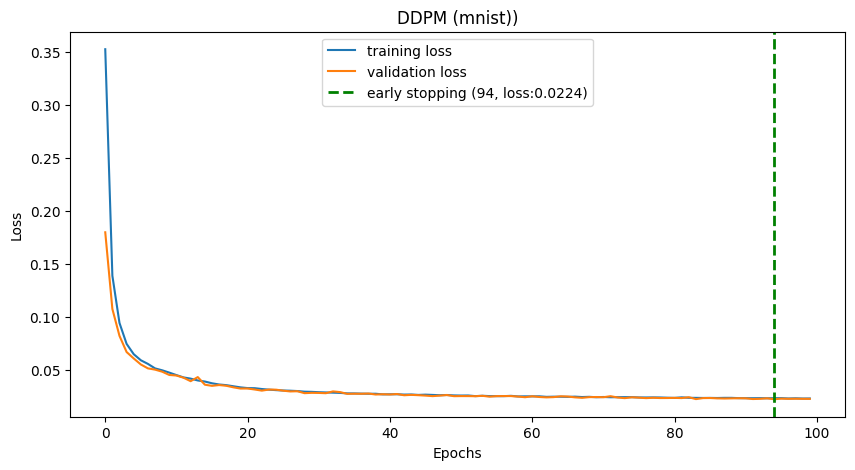

In [28]:
plt.figure(figsize=(10,5))
plt.title("DDPM (mnist))")
plt.plot(losses,label="training loss")
plt.plot(val_losses,label="validation loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch}, loss:{best_loss})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Process

model

In [19]:
resolution=32
in_channels=1
std_cnl=64
ted=256
ced=64

SAVED_PATH = './weight/ddpm_mnist_best.pth'

In [20]:
model = ResUNet(resolution, in_channels, std_cnl, ted, ced).to(device)

try:
    model.load_state_dict(torch.load(SAVED_PATH))
    model.eval()
    print('load model ok!')
except:
    print('error')

load model ok!


condition

In [21]:
c = [i%10 for i in range(100)]
c = np.array(c)

image setting

In [22]:
c_size = 10 
batch_size = c_size ** 2 
rsl = 32
width = rsl * 10
height = rsl * 10
channel = 1
ted = 256

make video (ddpm inversion)

In [90]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddpm/ddpm_mnist.avi', fourcc, 20, (height, width))
    out_img = np.zeros((height,width,3)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]
    
    # Inference 
    for t in range(timestep_num - 1, -1, -1): # 999 ~ 0 => 1000 step to 1 step 
        # time step, condition 
        emb_t = t_emb_set[t].view(-1, ted)
        emb_t = emb_t.expand(batch_size, ted).to(device) # [100, 256]
        emb_c = c_emb_set[c].to(device) # [100, 64]

        # forward 
        pred_noise = model(g_img, emb_t, emb_c)

        # get t-th images 
        z = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]
        mu = one_div_sqrt_alpha_list[t] * (g_img - (beta_list[t] / sqrt_one_minus_alpha_bar_list[t]) * pred_noise)
        g_img = mu + (torch.sqrt(beta_list[t])*z)
        # g_img = mu + (beta_list[t]*z)  # If use variance instead of std, you can get better fidelity but lower diversity! 
        g_img = torch.clip(g_img, -1.0, 1.0)

        # make numpy images
        g_np = torch.zeros_like(g_img) # [100, 1, 32, 32]
        g_np[:,0] = ((g_img[:,0] + 1.0) / 2.0) * 255. # mnist is only one channel (from -1~1 to 0~255)
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 1]
        
        # reshape numpy images
        rs_img = np.resize(g_np, (c_size, c_size, rsl, rsl)) # [10, 10, 32, 32]

        # make numpy images to grid image
        for i in range(c_size):
            for j in range(c_size):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :]

        # make video 
        out_img = np.uint8(out_img)
        out.write(out_img)

        # save grid image per 100 time step 
        if ((t+1) < 1000) and ((t+1) % 100 == 0):
            print(f'{t+1} step')
            file_path = f"./content/ddpm/{t+1}_step_img.png"
            cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddpm/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddpm ok!')

900 step
800 step
700 step
600 step
500 step
400 step
300 step
200 step
100 step
save video_ddpm ok!


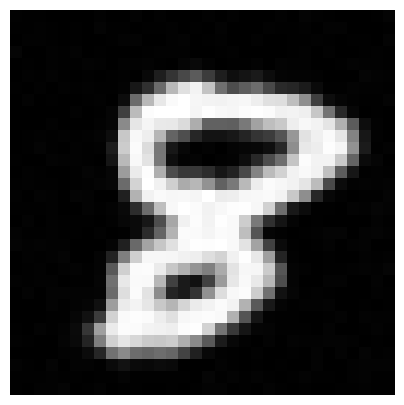

In [91]:
imshow(g_img[8].cpu())

make video (ddim inversion)

- eta = 0 -> ddim mode (low FID = high fidelity, diversity)
- eta = 1 -> ddpm mode (high FID = low fidelity, diversity)

In [92]:
total_timesteps  = 1000
sampling_timesteps = 100 # 10 times faster

In [93]:
def objective(ddim=True):
    if ddim:
        return 0
    else:
        return 1
    
eta = objective(True)
print('eta:',eta)

eta: 0


In [99]:
with torch.no_grad():
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('./content/ddim/ddim_mnist.avi', fourcc, 20, (width, height))
    out_img = np.zeros((height,width,3)) # [320, 320, 3]

    # get first image (noise)
    g_img = torch.randn((batch_size, 1, rsl, rsl), dtype=torch.float32).to(device) # [100, 1, 32, 32]

    # get time_pairs 
    times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]
    
    # Inference
    for time, time_next in time_pairs:
        emb_t = t_emb_set[time].view(-1, ted) # [100, 256]
        emb_c = c_emb_set[c].to(device) # [100, 64]

        # model forward 
        pred_noise = model(g_img, emb_t, emb_c)

        # set alpha
        alpha = alpha_bar_list[time]
        alpha_next = alpha_bar_list[time_next]
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_next = torch.sqrt(alpha_next)
    
        # predict x0
        numerator = g_img - (torch.sqrt(1-alpha) * pred_noise)
        pred_x0 = numerator / sqrt_alpha

        if time_next < 0:
            g_img = pred_x0
            continue
        
        # predict direction_pointing 
        sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha) * (1 - alpha / alpha_next))
        variance = sigma ** 2 
        direction_pointing = torch.sqrt(1-alpha_next-variance) * pred_noise

        # generate next image 
        g_img = (sqrt_alpha_next * pred_x0) + direction_pointing
        g_img = torch.clip(g_img, -1.0, 1.0)

        # make numpy images
        g_np = torch.zeros_like(g_img) # [100, 1, 32, 32]
        g_np[:,0] = ((g_img[:,0] + 1.0) / 2.0) * 255. # mnist is only one channel (from -1~1 to 0~255)
        g_np = g_np.permute(0,2,3,1).cpu().detach().numpy() # [100, 32, 32, 1]
    
        # reshape numpy images
        rs_img = np.resize(g_np, (c_size, c_size, rsl, rsl)) # [10, 10, 32, 32]

        # make numpy images to grid image
        for i in range(c_size):
            for j in range(c_size):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :]

        # make video 
        out_img = np.uint8(out_img)
        out.write(out_img)

        # save grid image per sampling time step 
        print(f'{time+1} step')
        file_path = f"./content/ddim/{time+1}_step_img.png"
        cv2.imwrite(file_path, out_img)

    # finish
    file_path = f"./content/ddim/last_img.png"
    cv2.imwrite(file_path, out_img)
    out.release()
    print('save video_ddim ok!')

1000 step
990 step
980 step
970 step
960 step
950 step
940 step
930 step
920 step
910 step
900 step
890 step
880 step
870 step
860 step
850 step
840 step
830 step
820 step
810 step
800 step
790 step
780 step
770 step
760 step
750 step
740 step
730 step
720 step
710 step
700 step
690 step
680 step
670 step
660 step
650 step
640 step
630 step
620 step
610 step
600 step
590 step
580 step
570 step
560 step
550 step
540 step
530 step
520 step
510 step
500 step
490 step
480 step
470 step
460 step
450 step
440 step
430 step
420 step
410 step
400 step
390 step
380 step
370 step
360 step
350 step
340 step
330 step
320 step
310 step
300 step
290 step
280 step
270 step
260 step
250 step
240 step
230 step
220 step
210 step
200 step
190 step
180 step
170 step
160 step
150 step
140 step
130 step
120 step
110 step
100 step
90 step
80 step
70 step
60 step
50 step
40 step
30 step
20 step
save video_ddim ok!


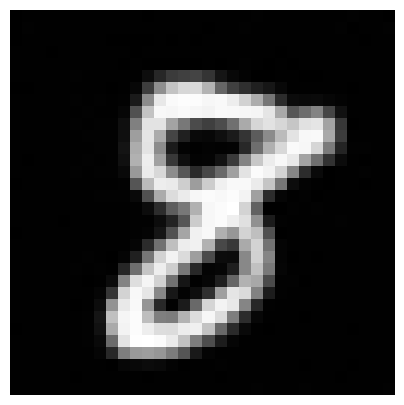

In [97]:
imshow(g_img[8].cpu())